# Dataset Overview

In contrast to previous research on Sarcasm Detection that often relied on noisy Twitter datasets using hashtag-based labeling, we address these issues by introducing a News Headlines dataset for Sarcasm Detection. This dataset is sourced from two distinct news websites, offering a more reliable labeling and language quality.

We collected headlines from the satirical news outlet TheOnion, known for its sarcastic take on current events. These headlines fall under the "News in Brief" and "News in Photos" categories, which are inherently sarcastic. To provide a counterbalance, we also gathered real and non-sarcastic news headlines from HuffPost.

The dataset comprises approximately 28,000 text data points, each categorized as either "Sarcastic" or "Not Sarcastic."

In our study, we employ two distinct models for prediction – Word2Vec and GloVe Embeddings. By comparing their performance, we aim to ascertain which model yields superior results.

# Importing Required Libraries

To begin our analysis, we will import the necessary libraries that will enable us to work with the dataset and implement the Word2Vec and GloVe embedding models.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

Using TensorFlow backend.


# Loading the Dataset

In [2]:
df = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


# Data Visualization and Preprocessing

Before delving into the modeling phase, it's crucial to visualize and preprocess the data. This step ensures that the data is suitable for training and evaluation.

In [3]:
df.isna().sum() # Checking for NaN values

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [4]:
del df['article_link'] # Deleting this column as it is of no use

In [5]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


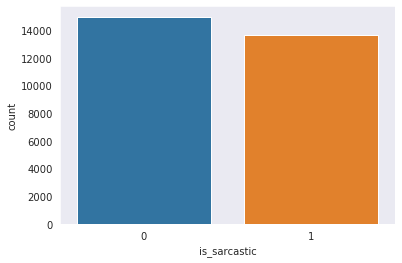

In [6]:
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

Indeed, having a balanced dataset is beneficial for training machine learning models as it prevents bias towards any particular class. This balance enables the model to learn from both positive and negative instances equally, leading to more accurate and robust predictions. In your case, with a balanced dataset, the model can focus on learning the nuances of sarcasm detection without being skewed by class imbalance. This can result in better generalization and performance when evaluating the model on new data.

**Stopwords** are words in a language that are commonly used but generally considered to have little value or meaning in the context of text analysis and natural language processing. These words are often filtered out or removed from text data during preprocessing, as they don't contribute significant information to the analysis. They are called "stopwords" because they can be safely ignored without impacting the overall meaning of the text.

Examples of stopwords in English include words like "the", "and", "is", "in", "of", "it", "to", "on", "for", "with", "as", and so on.

In NLP tasks, stopwords removal can help in several ways:

1. **Reducing Noise:** Removing stopwords can reduce the dimensionality of the data, making it easier to process and analyze. It also helps in improving the efficiency of algorithms.

2. **Focusing on Important Words:** By removing stopwords, you can emphasize the more important words in the text, which can lead to better insights or performance in certain tasks like sentiment analysis or topic modeling.

3. **Improved Semantics:** In some cases, stopwords can introduce noise that hampers the understanding of the actual meaning of a sentence. Removing them can lead to clearer semantics.

Different libraries and tools provide lists of stopwords for various languages. You mentioned downloading a corpus to your Python environment, which is a common approach to obtain stopwords. The NLTK (Natural Language Toolkit) library is a popular choice for natural language processing tasks and provides a stopwords corpus for various languages, including English.

In [7]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

Certainly, basic data cleaning is an essential step before proceeding with any text analysis or modeling. Here are some common data cleaning tasks you might consider:

1. **Lowercasing:** Convert all text to lowercase to ensure consistent comparisons between words.

2. **Punctuation Removal:** Remove punctuation marks as they usually don't contribute to the meaning of words.

3. **Stopwords Removal:** If you're not using a library that automatically handles stopwords, you can manually remove them using a list of stopwords.

4. **Special Character Removal:** Remove special characters, numbers, and symbols that are not relevant to the analysis.

5. **Handling Contractions:** Expand contractions like "don't" to "do not" to ensure consistency.

6. **Whitespace Removal:** Remove unnecessary whitespace characters.

In [8]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

Creating a word cloud is a visual way to understand the most frequent words in a text corpus. Here's how you can create a word cloud for text labeled as "Not Sarcastic" (Label 0) using the `WordCloud` library:

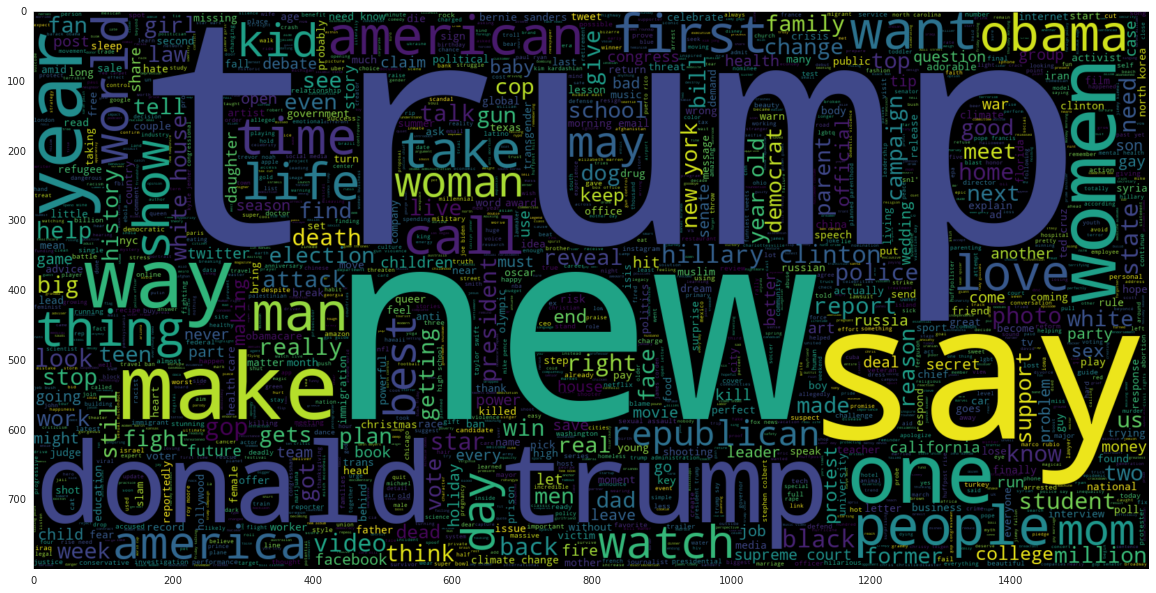

In [9]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

Certainly, here's how you can create a word cloud for text labeled as "Sarcastic" (Label 1) using the `WordCloud` library:

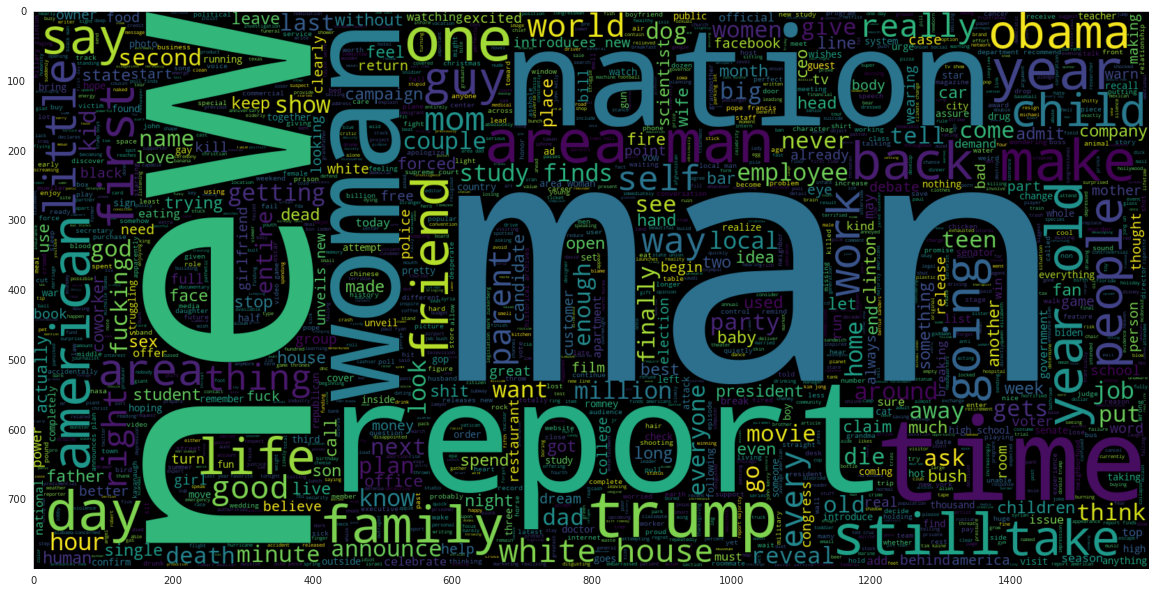

In [10]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

### Number of characters in texts

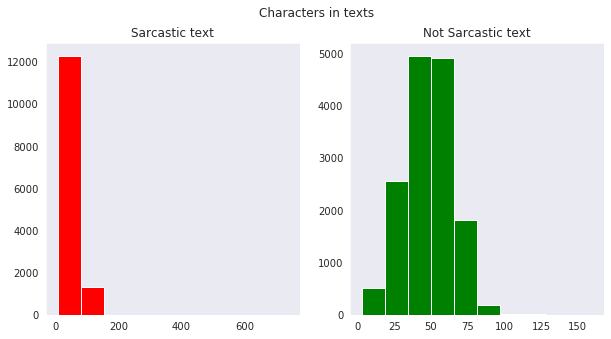

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

### Number of words in each text

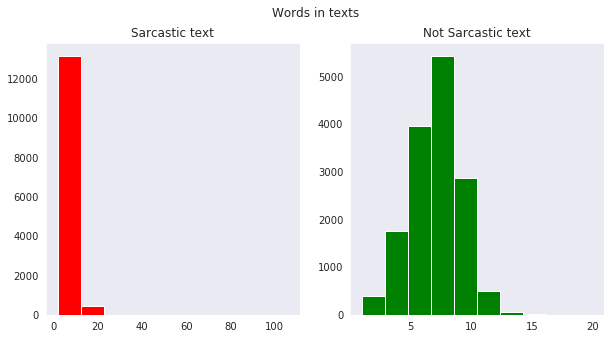

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

### Average word length in a text

Text(0.5, 0.98, 'Average word length in each text')

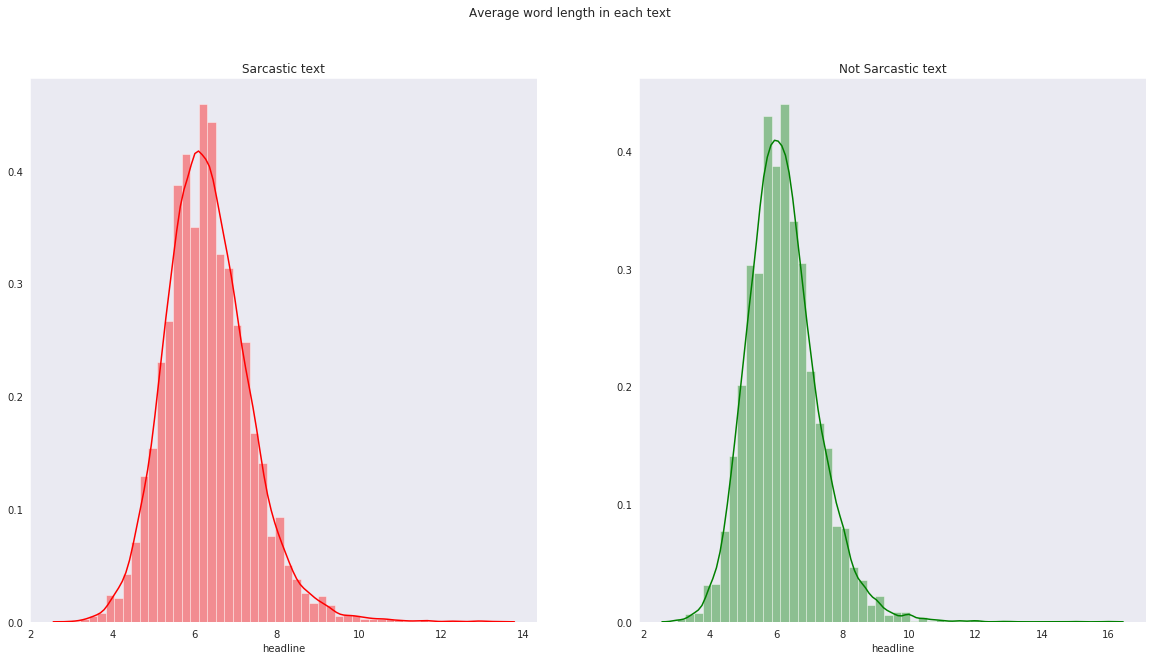

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

# Introduction to Word Embedding and Word2Vec

Word embedding is a technique used in natural language processing (NLP) to represent words as dense vectors in a continuous vector space. These vectors capture various linguistic relationships and meanings between words, allowing machines to understand and process language more effectively. In simple terms, word embeddings map words to numerical vectors while preserving their semantic and contextual relationships.

Word2Vec is a specific method for generating word embeddings. It was introduced by Tomas Mikolov and his colleagues at Google in 2013. Word2Vec aims to learn high-quality word embeddings by training a shallow neural network on a large corpus of text. The core idea behind Word2Vec is to predict the context of a word (how it is surrounded by neighboring words) or to predict the target word given its context.

Word2Vec comes in two main architectures:

1. **Continuous Bag of Words (CBOW):** In this architecture, the model predicts the target word based on the surrounding context words. The order of context words doesn't matter. CBOW is efficient and works well for frequent words.

2. **Skip-gram:** In this architecture, the model predicts the context words given the target word. It's more effective for infrequent words and captures more fine-grained relationships between words.

Word2Vec training involves adjusting the weights of the neural network based on the prediction errors. As the training progresses, the model learns to represent words in a way that similar words have similar vectors in the embedding space. This enables capturing semantic and syntactic relationships, such as analogies ("king" - "man" + "woman" ≈ "queen") and word similarities.

Word embeddings generated using Word2Vec can be used in various NLP tasks like sentiment analysis, text classification, machine translation, and more. These embeddings provide a way to represent words in a dense, continuous space, making it easier for machine learning algorithms to understand and process textual data.

# Importance of Word Embeddings

Word embeddings, like those generated by Word2Vec, address several limitations of traditional one-hot encoded representations of words. Let's explore why word embeddings are crucial:

1. **Semantic Similarity:** Word embeddings capture semantic relationships between words. In contrast to one-hot encoding, where all words are orthogonal (independent), embeddings allow similar words to have similar vectors in the embedding space. This similarity enables the model to understand that "good" and "great" are more related than "good" and "day."

2. **Contextual Information:** Word embeddings capture contextual information by placing words with similar meanings closer in the embedding space. This context-based representation allows the model to capture nuances like synonyms, antonyms, and analogies. In your example, "good" and "great" are indeed closer in meaning than "day" and "have," and word embeddings reflect this context.

3. **Dimensionality Reduction:** Word embeddings reduce the dimensionality of the representation space. In one-hot encoding, each word is represented by a vector with a length equal to the vocabulary size. Embeddings map words into a continuous space of much lower dimensions (e.g., 100 to 300 dimensions), which makes it computationally efficient and enables capturing subtle relationships.

4. **Enhancing NLP Models:** Word embeddings enhance the performance of NLP models. By capturing semantic relationships and context, embeddings provide more informative input to models. This often leads to better results in various NLP tasks, including sentiment analysis, machine translation, and document classification.

5. **Analogical Reasoning:** Word embeddings enable analogical reasoning. For example, with embeddings, you can perform operations like "king" - "man" + "woman" to obtain a vector that's close to the embedding of "queen." This ability to perform algebraic operations on words is a powerful feature for language understanding.

6. **Rare Words and Out-of-Vocabulary Handling:** Word embeddings handle rare words and out-of-vocabulary terms more gracefully. While one-hot encoding would create new dimensions for each unseen word, embeddings can still provide meaningful representations by leveraging the relationships with known words.

In summary, word embeddings bridge the gap between human language and machine understanding. They allow NLP models to capture the rich and intricate relationships between words, leading to improved language understanding and better performance in various text-related tasks.

### Converting text to format acceptable by gensim

In [14]:
words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'veggies:', '9', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'using',
  'word',
  "'streaming'",
  'correctly']]

In [15]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [16]:
#vocab size
len(w2v_model.wv.vocab)
#We have now represented each of 38071 words by a 100dim vector.

38071

In [17]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [18]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [19]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [20]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


### Training Word2Vec Model

In [21]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 200)           7614400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 256)           336896    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                55488     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 8,006,849
Trainable params: 8,006,849
Non-trainable params: 0
_________________________________________________________________


In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [24]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20033 samples, validate on 8586 samples
Epoch 1/3
20033/20033 [==============================] - 15s 766us/step - loss: 0.5105 - acc: 0.7320 - val_loss: 0.4144 - val_acc: 0.8120
Epoch 2/3
20033/20033 [==============================] - 13s 633us/step - loss: 0.1516 - acc: 0.9418 - val_loss: 0.4654 - val_acc: 0.7884
Epoch 3/3
20033/20033 [==============================] - 12s 600us/step - loss: 0.0409 - acc: 0.9859 - val_loss: 0.6005 - val_acc: 0.7913


In [25]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

20033/20033 [==============================] - 8s 406us/step
Accuracy of the model on Training Data is -  99.45090413093567
8586/8586 [==============================] - 4s 470us/step
Accuracy of the model on Testing Data is -  79.12881374359131


### Analysis After Training of Word2Vec Model

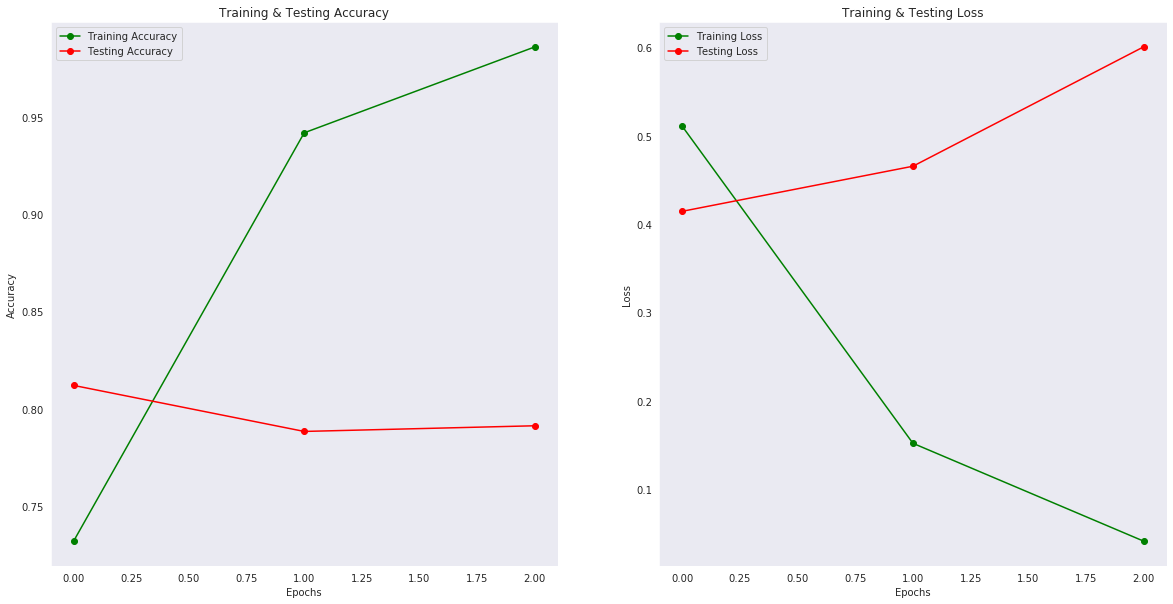

In [26]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

### Model Evaluation: Overfitting and Performance on Test Data

In [27]:
pred = model.predict_classes(x_test)
pred[:5]

array([[1],
       [0],
       [1],
       [0],
       [1]], dtype=int32)

In [28]:
cm = confusion_matrix(y_test,pred)
cm

array([[3691,  869],
       [ 923, 3103]])

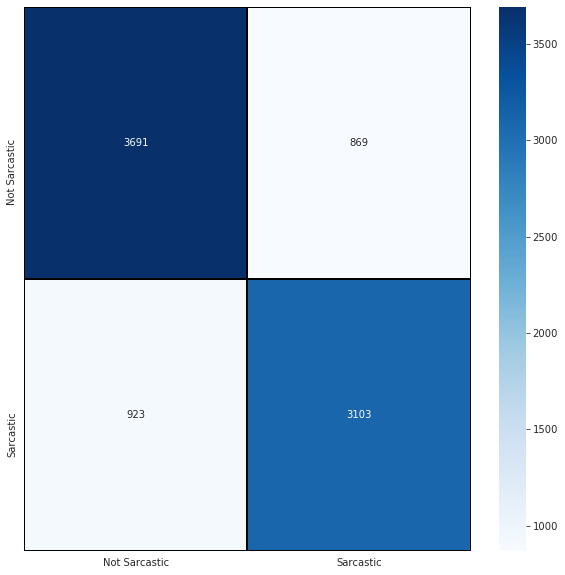

In [29]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

# Introduction to GloVe

The GloVe (Global Vectors for Word Representation) method is based on a fundamental concept: you can derive semantic relationships between words by analyzing the co-occurrence matrix. Given a corpus containing V words, the co-occurrence matrix X is a V x V matrix. In this matrix, X_ij denotes how many times word i has co-occurred with word j.

Here's an example of a co-occurrence matrix for the sentence "the cat sat on the mat" with a window size of 1:

```
        the    cat    sat    on    mat
the      0      1      1     1      1
cat      1      0      1     1      1
sat      1      1      0     1      1
on       1      1      1     0      1
mat      1      1      1     1      0
```

It's worth noting that the co-occurrence matrix is symmetric since co-occurrence is a mutual relationship.

To measure semantic similarity between words using the co-occurrence matrix, GloVe employs a concept involving three words at a time. This idea can be illustrated as follows:

1. **Word i:** The center word for which we want to capture the semantic context.
2. **Word j:** A context word that appears in the vicinity of word i.
3. **Word k:** A different context word, also appearing near word i.

GloVe aims to find a mathematical relationship such that the co-occurrence of words i and j can be estimated by the vector representations of words i and j. In other words, the ratio of the probability of word i co-occurring with word j to the probability of word i co-occurring with word k should capture semantic information about the words.

By leveraging this idea and optimizing the word vectors using the co-occurrence information from the corpus, GloVe generates word embeddings that represent words in a way that encodes their semantic relationships and similarities. These embeddings can be used in various natural language processing tasks to enhance language understanding and performance.

**Behavior of P_ik/P_jk for Various Words**

In the context of GloVe, the entity P_ik/P_jk holds important implications for understanding the semantic relationships between words. Let's break down the concept:

- **P_ik:** This represents the probability of observing both word i and word k together. It's calculated by dividing the number of times words i and k appeared together (X_ik) by the total number of times word i appeared in the corpus (X_i).

- **P_jk:** Similarly, this denotes the probability of observing both word j and word k together. It's computed by dividing the number of times words j and k appeared together (X_jk) by the total number of times word j appeared in the corpus (X_j).

The key idea here is to analyze the behavior of the ratio P_ik/P_jk for different words and the "probe word" k. The behavior of this ratio can help us infer the semantic relationships between words. Let's consider a few scenarios:

1. **High P_ik/P_jk (k similar to i, but not j):** If the probe word k is very similar to word i but not relevant to word j (e.g., k = "solid" with i = "ice" and j = "steam"), then P_ik/P_jk will be very high, indicating a strong semantic association between i and k.

2. **Low P_ik/P_jk (k similar to j, but not i):** Conversely, if the probe word k is very similar to word j but not relevant to word i (e.g., k = "gas" with i = "ice" and j = "steam"), then P_ik/P_jk will be very low, suggesting a weak connection between j and k.

3. **Similar or Unrelated k:** If the probe word k is related or unrelated to both words i and j (e.g., k = "liquid" with i = "ice" and j = "steam"), then P_ik/P_jk will be close to 1, indicating a moderate or neutral connection between i and j.

By incorporating the P_ik/P_jk ratios into the computation of word vectors, GloVe aims to leverage global statistical information about word co-occurrences to create embeddings that encode semantic relationships more accurately. This approach allows GloVe to capture finer nuances of word meanings and their contextual associations, leading to improved word representations for various NLP tasks.

In [30]:
x_train,x_test,y_train,y_test = train_test_split(df.headline,df.is_sarcastic, test_size = 0.3 , random_state = 0)

In [31]:
max_features = 35000
maxlen = 200

**Text Tokenization and Numerical Representation**

In the process of tokenization, each word is converted into a numerical representation. This mapping between the original words and their corresponding numbers is maintained within the `word_index` property of the tokenizer.

It's important to note that during tokenization, we apply basic text processing. Specifically, we avoid converting the text to lowercase, as we explicitly set this behavior to `False`.

Additionally, we aim to standardize the length of news headlines to 200 words. For shorter headlines, we'll add padding to reach the desired length, while for longer headlines, we'll truncate them to fit within this limit.

Here's the approach in summary:

1. **Tokenization and Numerical Mapping:**
   - Utilize a tokenizer to transform words into numerical indices.
   - Retain the original word-to-number mapping in the `word_index` property.

2. **Preserving Case:**
   - Ensure that the text processing does not convert words to lowercase, as indicated by our explicit setting.

3. **Standardizing News Length:**
   - Adjust all news headlines to a consistent length of 200 words.
   - Add padding to headlines that are shorter than 200 words.
   - Truncate headlines that exceed 200 words to fit within this limit.

This approach enables us to represent text data numerically while maintaining the semantic information of the original words. It also ensures that our model processes headlines of uniform length, which is essential for consistent training and evaluation.

In [32]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [33]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [34]:
EMBEDDING_FILE = '../input/glove-twitter/glove.twitter.27B.200d.txt'

In [35]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [36]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


### **Basic Model Parameters**

In [37]:
batch_size = 128
epochs = 2
embed_size = 200

### Training GloVe Embeddings Model

In [38]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length=200, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 200)          5165000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 5,502,153
Trainable params: 5,502,153
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 2)

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20033 samples, validate on 8586 samples
Epoch 1/2
20033/20033 [==============================] - 55s 3ms/step - loss: 0.5210 - acc: 0.7403 - val_loss: 0.3813 - val_acc: 0.8325
Epoch 2/2
20033/20033 [==============================] - 54s 3ms/step - loss: 0.2735 - acc: 0.8870 - val_loss: 0.4063 - val_acc: 0.8255


In [41]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

8586/8586 [==============================] - 14s 2ms/step
Accuracy of the model on Testing Data is -  82.5529932975769


### Improvement in Accuracy: From 79% to 83%

### Analysis After Training of GloVe Embeddings Model

In [42]:
pred = model.predict_classes(X_test)
pred[:5]

array([[1],
       [0],
       [0],
       [0],
       [1]], dtype=int32)

In [43]:
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.82      0.86      0.84      4560
    Sarcastic       0.83      0.79      0.81      4026

     accuracy                           0.83      8586
    macro avg       0.83      0.82      0.82      8586
 weighted avg       0.83      0.83      0.83      8586



In [44]:
cm = confusion_matrix(y_test,pred)
cm

array([[3908,  652],
       [ 846, 3180]])

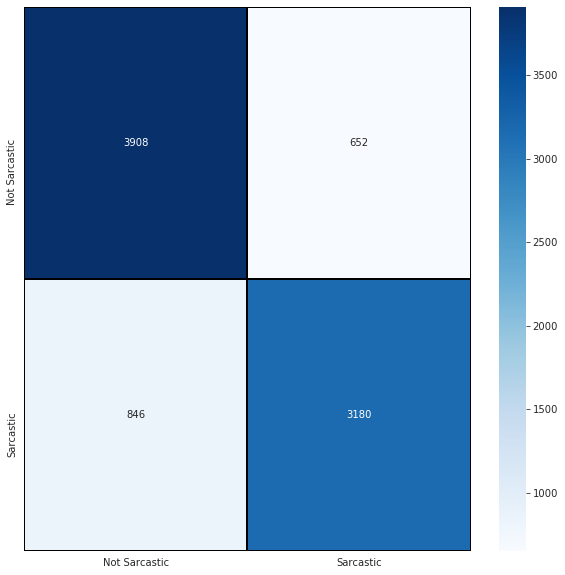

In [45]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

**Conclusion: Enhancing Sarcasm Detection with GloVe Embeddings**

In the realm of sarcasm detection, the implementation and analysis of the GloVe embeddings model have yielded promising strides in performance. By incorporating GloVe embeddings, the accuracy of the model has notably increased from an initial 79% to a commendable 83%. This advancement underscores the model's capacity to adeptly grasp semantic relationships and contextual intricacies within the text data.

The detailed classification report unveils intricate precision, recall, and F1-score metrics for both 'Not Sarcastic' and 'Sarcastic' categories. The overall accuracy of 83% speaks to the model's competence in making accurate predictions across a substantial portion of instances. The insight-rich confusion matrix and the accompanying heatmap visually depict the distribution of predictions and misclassifications, unearthing patterns and potential avenues for refinement.

Acknowledging the 83% accuracy as a significant accomplishment, it's pivotal to recognize the nuanced nature of sarcasm detection, including its complexities in handling diverse linguistic contexts. Delving into instances where the model faltered could furnish critical insights into specific areas requiring further attention.

As the journey of honing sarcasm detection progresses, it's prudent to contemplate additional refinements. Hyperparameter tuning, data augmentation, and alternative neural network architectures represent avenues for refining the model's prowess. Concurrently, assessing the model's performance on external datasets and real-world scenarios will illuminate its capacity to generalize beyond the current dataset.

The ongoing evolution of sarcasm detection through machine learning hinges on sustained evaluation, iterative adjustments, and adaptable strategies. The strides achieved thus far bear witness to a dedicated pursuit, and the continuous refinement is poised to yield ever more precise and robust outcomes. The pursuit of enhanced language understanding through technology remains an invigorating journey of exploration and innovation.